In [1]:
from __future__ import annotations

import sys
sys.path.append("../StateVecSimulator/latte")
sys.path.append("../StateVecSimulator")

import numpy as np

import simulation
import importlib
import _vec_intercept_sampler
import _noise
import vec_sim
importlib.reload(vec_sim)
importlib.reload(simulation)
importlib.reload(_vec_intercept_sampler)
importlib.reload(_noise)
from _vec_intercept_sampler import VecInterceptSampler
from _noise import NoiseModel
from simulation import *
from IPython import display
import matplotlib.pyplot as plt
import stim
import sinter
from tqdm.notebook import tqdm
from pyperclip import copy

In [2]:
simulation = RotatedSurfaceCodeSimulation(d = 3)

In [3]:
ghz_circuit_HXY = simulation.generate_projection_circuit_HXY()
syndrome_circuit = simulation.generate_syndrome_circuit()
injection_circuit_HXY = simulation.generate_injection_circuit_HXY(init_basis = 'z') 
double_ghz_circuit_HXY = simulation.generate_projection_double_ghz_HXY()

init_x_circuit = simulation.generate_init_circuit(basis = 'x')
injection_circuit_HXY_init_x = simulation.generate_injection_circuit_HXY(init_basis = 'x')

In [4]:

full_circuit = init_x_circuit + injection_circuit_HXY_init_x + double_ghz_circuit_HXY


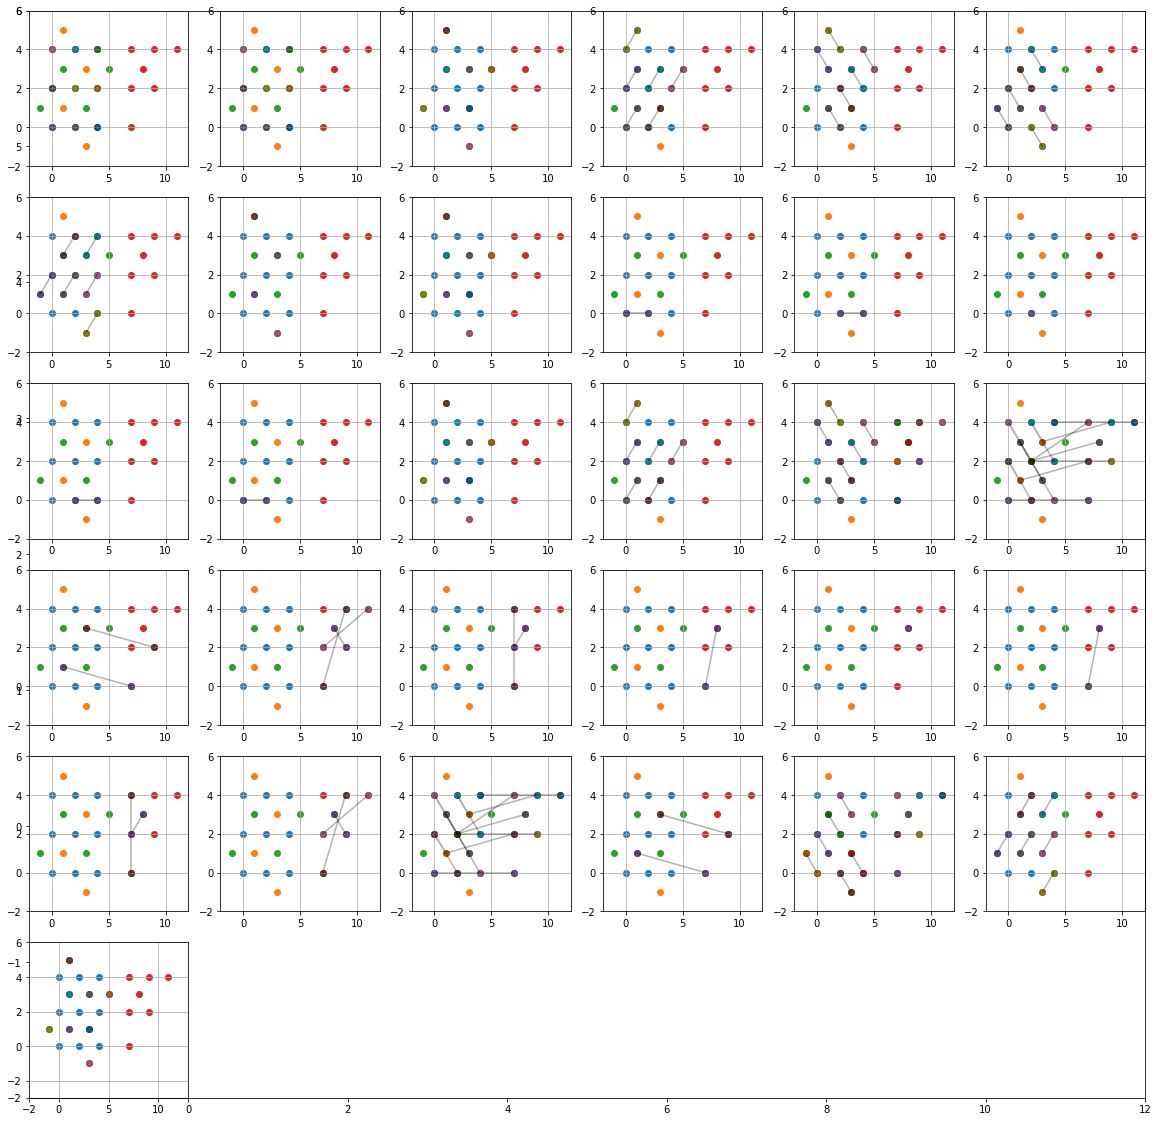

In [5]:
full_circuit.plot_timeline()

In [6]:
stim_circuit = init_x_circuit.to_stim_circuit(noise_model = None, p = 0, apply_non_cliffords = False, non_clifford_noise_strategy = "NOISE", logical_measurement_basis = 'x') \
     + (simulation.stim_expansion_circuit(d2 = 5, rounds = 3, logical_measurement_basis = 'x'))

In [7]:
stim_circuit.detector_error_model()

stim.DetectorErrorModel('''
    detector D0
    detector D1
    detector D2
    detector D3
    detector D4
    detector D5
    detector D6
    detector D7
    detector D8
    detector D9
    detector D10
    detector D11
    logical_observable L0
    detector(1, 1) D12
    detector(1, 5) D13
    detector(1, 9) D14
    detector(3, -1) D15
    detector(3, 3) D16
    detector(3, 7) D17
    detector(5, 9) D18
    detector(-1, 1) D19
    detector(1, 3) D20
    detector(3, 1) D21
    detector(5, 3) D22
    detector(7, 1) D23
    detector(7, 5) D24
    detector(9, 3) D25
    detector(9, 7) D26
    detector(1, 1) D27
    detector(1, 5) D28
    detector(1, 9) D29
    detector(3, -1) D30
    detector(3, 3) D31
    detector(3, 7) D32
    detector(5, 1) D33
    detector(5, 5) D34
    detector(5, 9) D35
    detector(7, -1) D36
    detector(7, 3) D37
    detector(7, 7) D38
    detector(-1, 1) D39
    detector(-1, 5) D40
    detector(1, 3) D41
    detector(1, 7) D42
    detector(3, 1) D43
    detect

In [8]:
copy(str(stim_circuit))

In [9]:
import pandas as pd
from joblib import Parallel, delayed
import numpy as np
from tqdm import tqdm

parallel = Parallel(n_jobs = -1)

# ps = [0, 1e-3, 2e-3, 4e-3]
ps = [0]#, 1e-3, 2e-3, 4e-3]
shots_per_batch = 10
total_shots = 50
num_batches = total_shots // shots_per_batch
post_select_syndromes = True

# circuit = short_double_injection_ghz_circuit
# final_state = 'H'

circuit = full_circuit
final_state = 'HXY'

# Pre-compile all samplers
samplers = {}
for p in ps:
    if p == 0:
        noise_model = None
    else:
        noise_model = NoiseModel.uniform_depolarizing(p=p)
    task = sinter.Task(circuit=circuit.to_stim_circuit(noise_model, p, post_select_syndromes = post_select_syndromes))
    samplers[p] = VecInterceptSampler(
        logical_x=[q.index for q in simulation.logical_x_qubits],
        logical_z=[q.index for q in simulation.logical_z_qubits]).compiled_sampler_for_task(task)

results = []
for batch in tqdm(range(num_batches)):
    # Cycle through all ps in each batch
    for p in tqdm(ps, leave = False):
        batch_results = parallel(delayed(samplers[p].sample)(shots=1, measured_operator = final_state) for _ in range(shots_per_batch))
        batch_results = sum(batch_results[1:], batch_results[0])  # Flatten results
        
        # Add metadata and save results
        results.append({
                'p': p,
                'batch': batch,
                'shots':  batch_results.shots,
                'discards' : batch_results.discards,
                'errors' : batch_results.errors
        })
        print(results[-1])
        

 20%|██        | 1/5 [00:26<01:44, 26.02s/it]

{'p': 0, 'batch': 0, 'shots': 10, 'discards': 0, 'errors': 0}


 40%|████      | 2/5 [00:50<01:14, 24.90s/it]

{'p': 0, 'batch': 1, 'shots': 10, 'discards': 0, 'errors': 0}


 60%|██████    | 3/5 [01:14<00:49, 24.75s/it]

{'p': 0, 'batch': 2, 'shots': 10, 'discards': 0, 'errors': 0}


 80%|████████  | 4/5 [01:38<00:24, 24.24s/it]

{'p': 0, 'batch': 3, 'shots': 10, 'discards': 0, 'errors': 0}


100%|██████████| 5/5 [02:01<00:00, 24.25s/it]

{'p': 0, 'batch': 4, 'shots': 10, 'discards': 0, 'errors': 0}
